# My financial journey


After a few years interested in the fianancial market, looking back I made a ton of mistakes and they made a better investor.

First of all, let me present myself. My name is Rafael, I am a undergraduate at University of São Paulo, studying Computer Information Systems. Working as a intern in a Asset Manegment Firm.

My journey in the financial market began with the 2018 bull market, it was the first time the Ibovespa hit 100k points and investing was becoming more accessible to the average Joe, with brokers like XP inc. offering the low fees to invest and user friendly experience to investing. Followed by this, the rise of fianancial influencer, like Thiago Nigro, also know as Primo Rico, explaning about the diverse products and how they could help the average person, not just the rich ones, to achive theirs financial goals.

You can cleary see this in the image bellow, with the vertical axis representing the amount of investors:

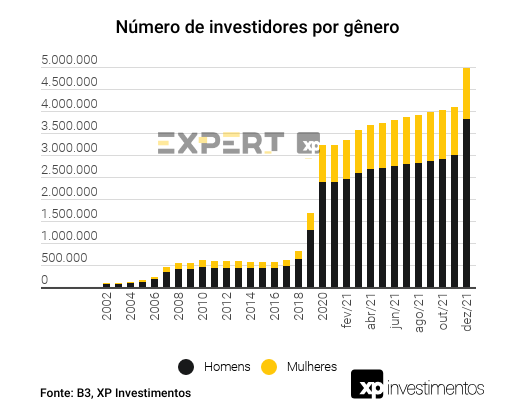

At home I also had a big influence in my dad, that always incentivise me and my brother to save money. His biggest incentive was the allowence he gave us, but it had a bonus, every end of the month it would compound 10%, giving us the idea of money in time.

During this time, I was in high school and a few friends of mine began to talk about making money in the market, also during that time the Youtube algorithm began to promote a lot of content related to finance. That made me research investing methods that would make the biggest amount of money in the least amount of time. 

With that goal in mind, i found technical analysis, with the two most prommissing tecniques been, moving averages and momentum investing. In this article i plan to discuss how these technics work and if they can produce results to the average person.

## Simple double moving averages investing

Moving averages trading is a technical analysis tool the involves two moving averages of a time-series, one long, signifing the longer term trend in the asset, and one short, signifing the short term trend. When the short term trend is above the long term one, the market is signaling a upward trend, so it's a buy signal. The oposite is true, when the long term trend is above the short term one, the market is in a downward trend.

The mathematical formula for the moving averages at a given time $t$:

$$
\begin{align}
a_{L, t} = \frac{1}{L}\sum^{L}_{j=1}p_{t - L + j} && a_{s, t} = \frac{1}{S}\sum^{S}_{j=1}p_{t - S + j}
\end{align}
$$

With $L$ being the long period, and $S$ being the short. To identify if the time $t$ is a buy, sell signal or neutral signal, we use the following ratio:

$$
R_t = \frac{a_{S, t} - a_{L, t}}{a_{L, t}}
$$

And the classification process, goes as following:
$$
Signal_t = 
\begin{aligned}
\begin{cases}
Buy: && R_t \gt B \\ 
Neutral: && -B \le R_t \le B \\
Sell: && R_t \lt -B
\end{cases}
\end{aligned}
$$

B is the bandwith of trading, if it's 0 every day you have a trading position.

Below a code that implements a simple moving average algorithm.

<Axes: xlabel='Date'>

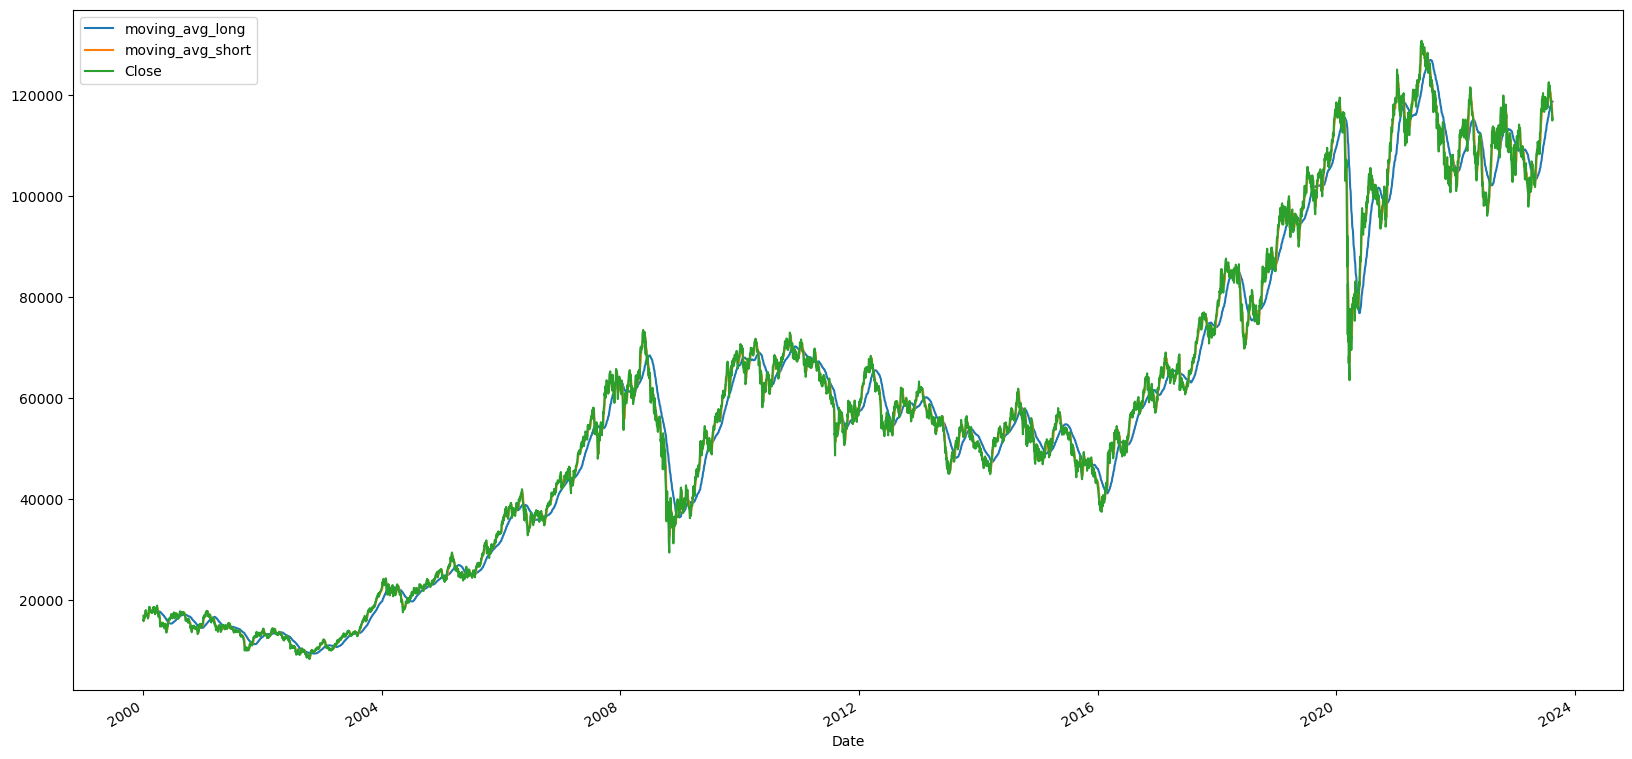

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from bcb import sgs

def moving_avg(time_serie: pd.Series, 
               period_long: int, 
               period_short: int,
               b: float = 0):
    df = time_serie.to_frame()
    df["moving_avg_long"] = time_serie.rolling(window=period_long).mean()
    df["moving_avg_short"] = time_serie.rolling(window=period_short).mean()
    df["ratio"] = (df["moving_avg_short"] - df["moving_avg_long"])/df["moving_avg_long"]
    def signal(x, b):
        if x > b:
            return 2
        elif x < -b:
            return 0
        else:
            return 1
    df["signal"] = df["ratio"].apply(signal, b=b)
    return df
web = yf.Ticker("^BVSP")
df_ibov = web.history(start=datetime.datetime(2000, 1, 1))["Close"]
df_ibov.index = pd.to_datetime(df_ibov.index).tz_localize(None)
selic = (sgs.get({"selic":432}, start = '2000-01-01')/100 + 1) ** (1/360)
series = moving_avg(df_ibov, 50, 5)
series[["moving_avg_long", "moving_avg_short", "Close"]].plot.line(figsize=(20, 10))

The algorithm is simple, using rolling windows to calculate the average for each time step and returning a dataframe with the averages and the classification for each period, with 2 being a buy signal, a 1 being a neutral position and a 0 a sell signal. Now that we have a working algorithm we can calculate if it generate profit or loss.

This function not only calculate the return, but also can account for taxes (we will see this later), and calculate the market return and the volatility of each estrategy.

In [40]:
def returns_moving_averages(df: pd.DataFrame,
                            risk_free_rate: pd.Series,
                            taxes = False) -> dict:
    df.dropna(inplace=True)
    return_buy = None
    return_sell = None
    last = None
    if taxes:
        tax = 0.8
    else:
        tax = 1
    risk_free_return = np.prod(risk_free_rate.values, dtype=np.float64)
    for ind, row in enumerate(df.to_dict("records")):
        if ind == 0:
            continue
        if row["signal"] == df.iloc[ind-1, -1]:
            if row["signal"] == 2:
                return_tmp = row["Close"]/df.iloc[ind-1, 0]
                if return_tmp > 1:
                    return_day = [[df.index[ind], return_tmp*tax]]
                else:
                    return_day = [[df.index[ind], return_tmp]]
                if return_buy is None:
                    return_buy = np.array(return_day)
                else:
                    return_buy = np.append(return_buy, return_day, axis=0)
            elif row["signal"] == 0:
                return_tmp = df.iloc[ind-1, 0]/row["Close"]
                if return_tmp > 1:
                    return_day = [[df.index[ind], return_tmp*tax]]
                else:
                    return_day = [[df.index[ind], return_tmp]]
                if return_sell is None:
                    return_sell = np.array(return_day)
                else:
                    return_sell = np.append(return_sell, return_day, axis=0)

    return_buy_signal = np.nanprod(return_buy[:, 1])
    return_sell_signal = np.nanprod(return_sell[:, 1])
    return_total = return_buy_signal*return_sell_signal
    asset_return = df["Close"][-1]/df["Close"][0]
    volatility_total = np.nanstd(np.append(return_buy[:, 1], return_sell[:, 1]), ddof=1)
    volatility_buy_signal = np.nanstd(return_buy[:, 1], ddof=1)
    volatility_sell_signal = np.nanstd(return_sell[:, 1], ddof=1)
    asset_volatility = np.nanstd(df["Close"].pct_change()+1)

    return {"return total": return_total,
            "volatility total": volatility_total,
            "return buy signal": return_buy_signal,
            "volatility buy signal": volatility_buy_signal,
            "return sell signal": return_sell_signal,
            "volatility sell signal": volatility_sell_signal,
            "asset returns": asset_return,
            "asset volatility": asset_volatility,
            "sharpe ratio": (return_total-risk_free_return)/volatility_total,
            "return array buy signal": return_buy,
            "return array sell signal": return_sell}

In [42]:
results = returns_moving_averages(series, selic)
print(f"The returns of the buy and sell signals {round((results['return total'] - 1)*100, 2)}%")
print(f"The returns of the buy signals {round((results['return buy signal'] - 1)*100, 2)}%")
print(f"The returns of the sell signals {round((results['return sell signal'] - 1)*100, 2)}%")
print(f"The market return was {round((results['asset returns'] - 1)*100, 2)}%")
print(f"The sharpe ratio was {round(results['sharpe ratio'], 2)}%")

The returns of the buy and sell signals 4243.19%
The returns of the buy signals 1484.87%
The returns of the sell signals 174.04%
The market return was 563.84%
The sharpe ratio was 1558.49%


As you can see we got really good, 8 times the results of the market. And that was what really caught my eyes in the beggining of the journey, it was almost magical, in 20 years you could multiply your money by 42 fold, while the market "only" gave almost 7 times. But maybe that was luck, lets try a wide range of parameters and windows of returns to see if this strategy still holds true

In [53]:
def backtest(time_series, risk_free, folds_window=(1, 8, 4), long_window = (50, 100, 5), short_window = (1, 10, 4), b_range=(0, 0.01, 2),taxes = False):
    """
    Recives a time series as input an compute the moving averages for combintions of periods. Return a DataFrame with returns, volatility and market information. 
    The index describe the iteration with the structure (long window, short window, b, period)
    
    The parameters [long_window, short_window, b_range], follow the patern (start, stop, num).
    
    Parameter
    """
    data = pd.DataFrame([])
    for folds_series in np.linspace(start=folds_window[0], stop=folds_window[1], num=folds_window[2], dtype=int):
        folds = [time_series.iloc[int((i/folds_series)*time_series.shape[0]):int(((i+1)/folds_series)*time_series.shape[0])] for i in range(folds_series)]
        for num, fold in enumerate(folds):
            risk_free_fold = risk_free.loc[fold.index]
            for long in np.linspace(start=long_window[0], stop=long_window[1], num=long_window[2], dtype=int):
                for short in np.linspace(start=short_window[0], stop=short_window[1], num=short_window[2], dtype=int):
                    for b in np.linspace(start=b_range[0], stop=b_range[1], num=b_range[2], dtype=float):
                        results = returns_moving_averages(moving_avg(fold, long, short, b), risk_free_fold, taxes)
                        data = pd.concat([data, pd.DataFrame([(results['return total']**(252/fold.shape[0]) - 1)*100,
                                                              (results["asset returns"]**(252/fold.shape[0]) - 1)*100, 
                                                              (results['return buy signal']**(252/fold.shape[0]) - 1)*100, 
                                                              (results['return sell signal']**(252/fold.shape[0]) - 1)*100,
                                                              (results['volatility total']*100*np.sqrt(252)),
                                                              (results['volatility buy signal']*100*np.sqrt(252)), 
                                                              (results['volatility sell signal']*100*np.sqrt(252)),
                                                              (results['asset volatility']*100*np.sqrt(252)),
                                                              (results['sharpe ratio']),
                                                              (f"{fold.index[0].strftime('%Y-%m')}-{fold.index[-1].strftime('%Y-%m')}"),
                                                              (f"{long}, {short}, {b}")],  # add Sharpe
                                                             index=["Annualized Returns Total", 
                                                                    "Annualized Asset Return", 
                                                                    "Annualized Returns Buy Signal", 
                                                                    "Annualized Returns Sell Signal", 
                                                                    "Annualized Volatility Total", 
                                                                    "Annualized Volatility Buy", 
                                                                    "Annualized Volatility Sell",
                                                                    "Asset Annualized Volatility",
                                                                    "Sharpe Ratio",
                                                                    "Period",
                                                                    "Window"], 
                                                             columns=[f"{long}, {short}, {b}, {fold.index[0].strftime('%Y-%m')}-{fold.index[-1].strftime('%Y-%m')}"]).T], axis=0) #Adicionar o periodo
    data = data.astype({"Annualized Returns Total" : np.float64, 
                        "Annualized Asset Return" : np.float64, 
                        "Annualized Returns Buy Signal" : np.float64, 
                        "Annualized Returns Sell Signal" : np.float64, 
                        "Annualized Volatility Total" : np.float64, 
                        "Annualized Volatility Buy" : np.float64, 
                        "Annualized Volatility Sell": np.float64,
                        "Asset Annualized Volatility" : np.float64,
                        "Sharpe Ratio" : np.float64})
    return data

In [55]:
backtest_results = backtest(df_ibov, selic)

In [56]:
backtest_results.describe()

,Annualized Returns Total,Annualized Asset Return,Annualized Returns Buy Signal,Annualized Returns Sell Signal,Annualized Volatility Total,Annualized Volatility Buy,Annualized Volatility Sell,Asset Annualized Volatility,Sharpe Ratio
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,19.348674,7.831488,13.049939,5.573498,27.557124,22.632751,34.015589,27.409085,3411.258584
std,13.417936,12.115387,9.742080,7.415917,4.846352,2.945120,10.108101,4.609166,40247.772990
min,-3.788116,-16.357856,-6.404653,-14.055130,18.893271,16.243849,20.443168,20.175731,-32.788946
25%,10.183569,-1.190954,6.720646,0.470984,23.795507,20.007375,25.488055,23.766294,7.277245
50%,17.572814,8.494042,11.604454,4.584556,27.656878,22.715168,33.850925,27.369408,28.822849
75%,24.572045,14.409652,18.867267,9.784959,31.062077,24.811488,36.000275,31.002676,82.950911
max,67.161358,46.916889,46.788913,41.571587,37.930762,30.194624,61.250719,36.990867,717159.702121


## Exploratory analysis of the periods

Now that we have the reasults from the backtest we can explore to edentify patterns and the best parameters across the data.

First we try to identify wha is the window that best perfomed across all the periods.

In [57]:
windows = {}
for row in backtest_results.to_dict("records"):
    if row["Window"] in windows:
        windows[row["Window"]].append(row)
    else:
        windows[row["Window"]] = [row]

window_stats = pd.DataFrame([])
for window in windows.keys():
    df_tmp = pd.DataFrame(windows[window])
    window_stats = pd.concat([window_stats, pd.DataFrame({
        window:{
            "mean annualized return": np.mean(df_tmp["Annualized Returns Total"]),
            "mean excess returns": np.mean(df_tmp["Annualized Returns Total"] - df_tmp["Annualized Asset Return"]),
            "std annualized return": np.std(df_tmp["Annualized Returns Total"]),
            "std excess returns": np.std(df_tmp["Annualized Returns Total"] - df_tmp["Annualized Asset Return"]),
            "mean sharpe ratio": np.mean(df_tmp["Sharpe Ratio"])
    }})], axis=1)
window_stats.sort_values("mean annualized return", axis=1)

,"100, 10, 0.0","87, 10, 0.0","100, 10, 0.01","100, 7, 0.01","87, 10, 0.01","75, 10, 0.01","87, 7, 0.0","100, 7, 0.0","87, 7, 0.01","75, 10, 0.0",...,"100, 1, 0.0","100, 1, 0.01","87, 1, 0.01","87, 1, 0.0","75, 1, 0.01","75, 1, 0.0","62, 1, 0.01","62, 1, 0.0","50, 1, 0.01","50, 1, 0.0"
mean annualized return,9.072500,9.086286,9.382745,10.162907,10.239901,10.323152,10.476920,10.519739,10.625707,10.766945,...,27.837036,28.334504,31.824018,32.632450,36.099325,37.244531,40.059172,40.234540,47.540833,47.754036
mean excess returns,2.197524,1.390675,2.507769,3.287931,2.544291,1.933065,2.781309,3.644763,2.930096,2.376857,...,20.962060,21.459528,24.128407,24.936839,27.709237,28.854444,32.388530,32.563899,39.014709,39.227913
mean sharpe ratio,11.188671,9.161556,16.150853,24.490672,22.479383,18.956666,20.883196,27.342571,23.319050,27.876921,...,1963.124213,2065.219433,3286.907074,3589.105895,6552.560461,8144.743857,12076.793032,13254.230550,40501.019629,42541.453689
std annualized return,7.654225,7.180929,7.502974,7.021123,8.418035,7.232027,8.344673,8.001195,7.224563,7.673895,...,9.282680,9.419807,10.060882,11.110870,9.003074,11.100451,9.158863,8.009396,10.332580,9.406544
std excess returns,7.453842,8.259502,7.876836,8.673065,9.010100,10.066531,9.288977,7.669936,8.792577,10.708735,...,9.576244,9.469904,9.431483,10.792516,10.824249,11.726185,14.155233,14.225980,16.304228,16.832792


As we can see above, the short average has a bigger impact than the longer one, with smaller windows having an edge over the longer ones in both cases, this can be due to the higher frequency of trades and capturing shorter trades trends that benefit the investor. But all windows have beatten the market, on average. That's good news for our trading strategy, now that we have the best windows lets try to identify when the strategy best performs on time.

In [59]:
best_window = window_stats.sort_values("mean annualized return", axis=1).columns[-1]
backtest_results_best_window = backtest_results[backtest_results["Window"] == best_window]
results_best_params = pd.DataFrame({"Returns": backtest_results_best_window["Annualized Returns Total"],
                                    "Excess Returns": backtest_results_best_window["Annualized Returns Total"] - backtest_results_best_window["Annualized Asset Return"],
                                    "Volatility": backtest_results_best_window["Annualized Volatility Total"],
                                    "Asset volatility": backtest_results_best_window["Asset Annualized Volatility"],
                                    "Sharpe Ratio": backtest_results_best_window["Sharpe Ratio"]})
results_best_params.sort_values("Excess Returns", ascending=False).iloc[[*range(5), *range(-5, 0)]]

,Returns,Excess Returns,Volatility,Asset volatility,Sharpe Ratio
"50, 1, 0.0, 2000-01-2002-12",61.731892,77.369086,32.629994,33.026346,128.161274
"50, 1, 0.0, 2000-01-2004-09",64.738352,58.644272,30.531291,31.014223,436.558800
"50, 1, 0.0, 2005-11-2008-11",57.436974,58.066017,35.408396,36.109827,109.619950
"50, 1, 0.0, 2007-11-2015-10",49.709729,52.708910,28.341590,29.168425,1175.042513
"50, 1, 0.0, 2011-10-2014-10",44.611079,45.494650,20.350008,20.962806,134.064142
"50, 1, 0.0, 2015-10-2023-08",42.254882,29.326809,25.163252,25.479805,866.882321
"50, 1, 0.0, 2008-11-2011-10",39.700593,26.480041,24.097531,25.088703,92.753369
"50, 1, 0.0, 2014-03-2018-11",36.876693,24.785265,22.211287,23.766294,206.201523
"50, 1, 0.0, 2014-10-2017-09",36.719184,20.202760,21.946162,23.671095,86.764706
"50, 1, 0.0, 2002-12-2005-11",47.725127,0.808238,25.514510,26.077620,103.259705


C:\Users\rafael.moraes\AppData\Local\Temp\ipykernel_9044\1056287301.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  res = returns_moving_averages(series.loc[datetime.datetime(year=2007, month=11, day=1):datetime.datetime(year=2015, month=10, day=1)])
C:\Users\rafael.moraes\AppData\Local\Temp\ipykernel_9044\3580683853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\rafael.moraes\AppData\Local\Temp\ipykernel_9044\1056287301.py:3: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  (series.loc[dateti

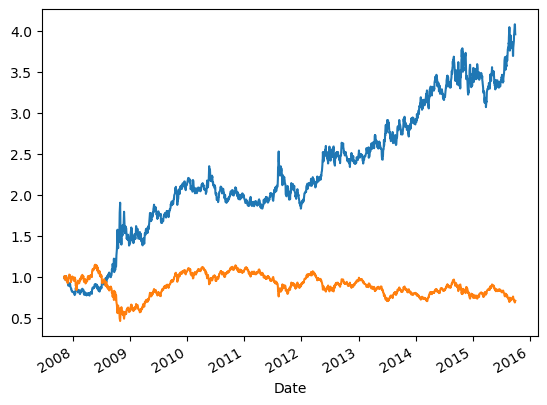

In [9]:
res = returns_moving_averages(series.loc[datetime.datetime(year=2007, month=11, day=1):datetime.datetime(year=2015, month=10, day=1)])
ax = pd.DataFrame(np.append(res["return array buy signal"], res["return array sell signal"], axis=0)).sort_values(0).set_index(0).cumprod().plot.line(legend=False)
(series.loc[datetime.datetime(year=2007, month=11, day=1):datetime.datetime(year=2015, month=10, day=1)]["Close"].pct_change()+1).cumprod().plot.line(ax=ax)
plt.show()

In [13]:
backtest_results[""]backtest_results.index.str[:6]

Index(['50, 1,', '50, 1,', '50, 4,', '50, 4,', '50, 7,', '50, 7,', '50, 10',
       '50, 10', '62, 1,', '62, 1,',
       ...
       '87, 10', '87, 10', '100, 1', '100, 1', '100, 4', '100, 4', '100, 7',
       '100, 7', '100, 1', '100, 1'],
      dtype='object', length=680)

Everything always looks amazing, only in the worst case scenario you get results that are worst to the market. On average you are getting 3.5% more returns, per period and on the best cases you get 50% more returns. It seems like you beat the market and não it's just wait and retire early. But as my father always told me, "there is no free launch". At the time i didn't care about transaction costs and taxes and that was the catch. If a strategy so good and so easily distributed, the market is efficient enought to precify it, so it becomes not profitable in relation to the risk-free rate, this was demonstraded by XXX (Taylor).

In Brazil, whenever you trade above 20K R$ you have to pay 20% of your profits in taxes, only accounting for that we can change the previous formula to account for that. That really bad for our strategy due to high frquency of trading that is involved in the strategy. We can see the results below.

<Axes: >

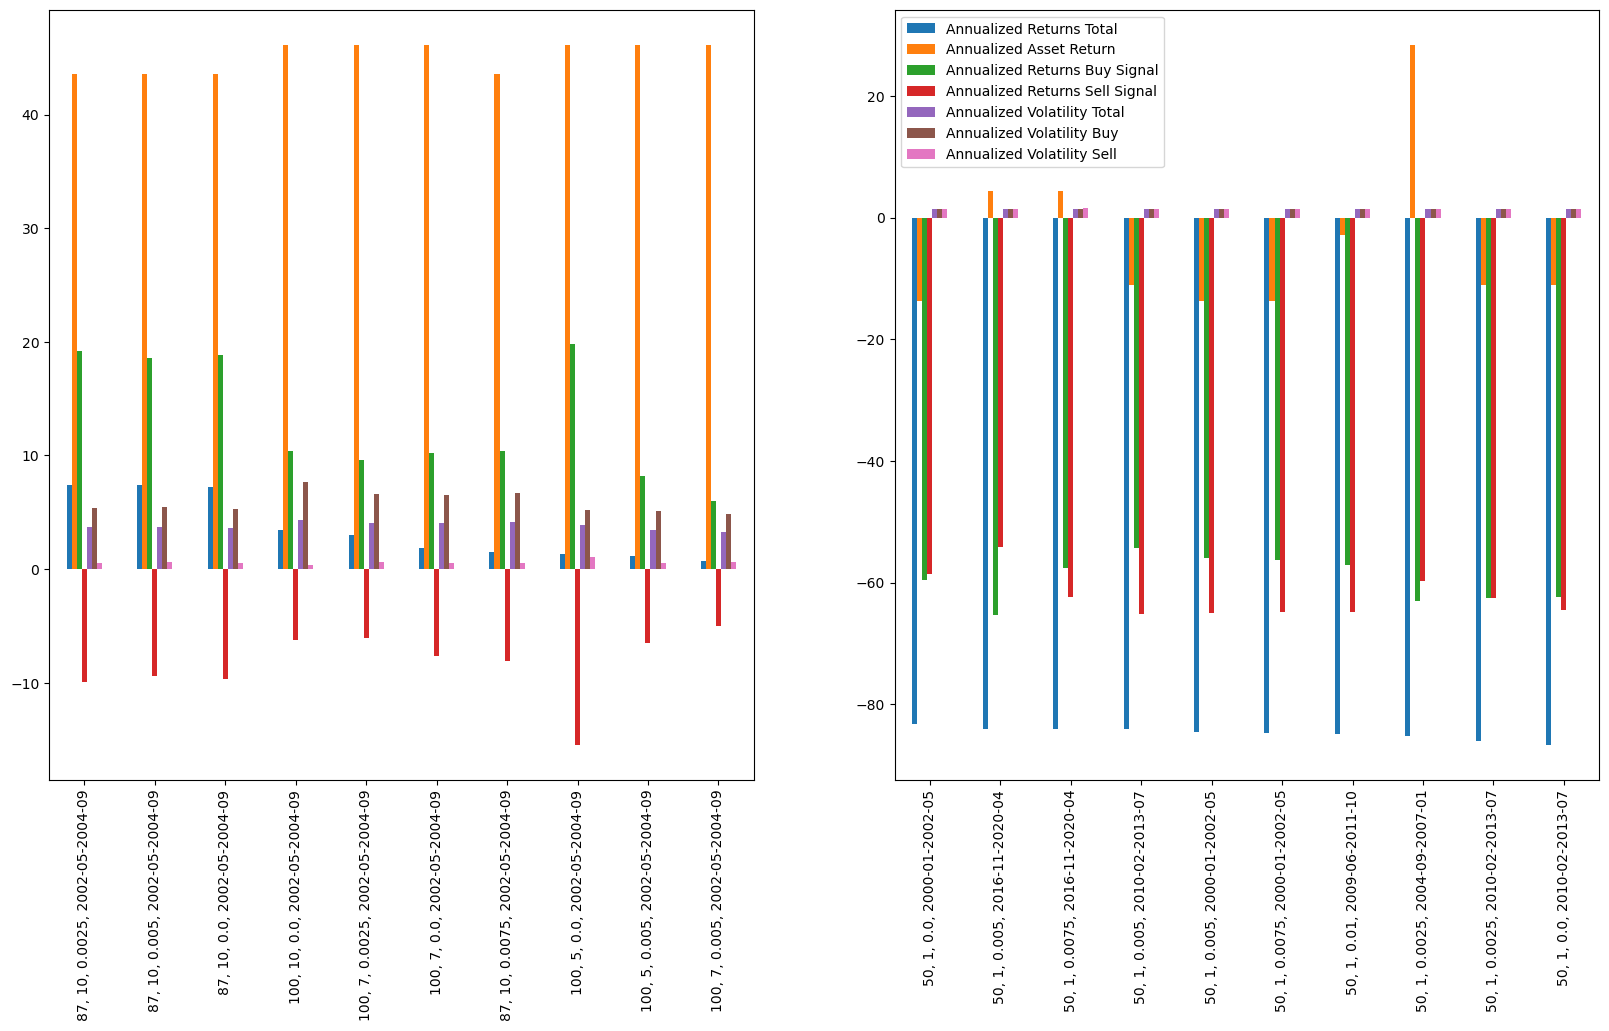

In [39]:
backtest_tax_results = backtest(df, taxes=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
backtest_tax_results.sort_values("Annualized Returns Total", ascending=False).tail(10).plot.bar(ax=ax[1])
backtest_tax_results.sort_values("Annualized Returns Total", ascending=False).head(10).plot.bar(ax=ax[0], legend=False)

In [40]:
backtest_tax_results.describe()

,Annualized Returns Total,Annualized Asset Return,Annualized Returns Buy Signal,Annualized Returns Sell Signal,Annualized Volatility Total,Annualized Volatility Buy,Annualized Volatility Sell
count,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000
mean,-37.967728,7.147449,-23.346395,-20.371207,1.325900,1.376640,1.200803
std,16.502733,13.295817,12.953144,12.091860,0.411763,0.610528,0.435725
min,-86.623807,-14.922816,-66.284832,-69.501539,0.364108,0.035937,0.053698
25%,-45.534301,-3.785571,-29.592470,-24.365408,1.065734,1.085736,0.948714
50%,-35.961188,4.602974,-22.235691,-18.086762,1.233312,1.247789,1.148018
75%,-26.626276,14.533196,-15.307616,-12.860941,1.462017,1.452327,1.387886
max,7.367944,46.440600,19.825521,7.269139,4.627115,7.638216,3.236308


# Concluision

In this first part we saw how a simple double moving average works and understanding why it doesn't work in the real world. But that is not all that there is to it, trading rules like the one described in this article can e used to identify trend and imbalances in the the market due to the information you can get by the diference in the returns of buy and sell signals, identifying the distribution od these signal can give important data about the market. These strategies were also deeply used to prove or disprove the Efficient Market Hipotesysis, but thats a topic for a future episode in this series. 

If you want to dive deeper into this topic, I reccomend the book Asset price dynamics, volatility, and prediction by Stephen Taylor. This book was the base for this article and it dives into different markets and how trading rules can be used to get useful information.